In [2]:
import numpy as np
from astropy.io import fits
import pylab as pl
import healpy as hp
from glob import glob

In [11]:
import matplotlib.colors as colors

# Check one file

In [3]:
root = "/global/cfs/cdirs/desicollab/users/lauracdp/photo-z_box/uncontaminated_mocks/mock_analysis/qq_desi_y3/skewers_desi_footprint.5/analysis-0/jura-0/baseline/"

root += "deltas_lya/Delta/"

In [4]:
example_file = root + "delta-1375.fits.gz"
hdu=fits.open(example_file)

In [40]:
# print table information:
hdu.info

<bound method HDUList.info of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f2eac43ed90>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f2e7833d790>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7f2e779eaee0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f2e775135b0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f2e7753a850>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f2e775962b0>]>

In [41]:
len(hdu)

6

In [47]:
for i in range(1, len(hdu)):
    print(i)
    print(hdu[i].header)
    print("\\")

1
XTENSION= 'IMAGE   '           / IMAGE extension                                BITPIX  =                  -64 / number of bits per data pixel                  NAXIS   =                    1 / number of data axes                            NAXIS1  =                 2716 / length of data axis 1                          PCOUNT  =                    0 / required keyword; must = 0                     GCOUNT  =                    1 / required keyword; must = 1                     EXTNAME = 'LAMBDA  '                                                            BUNIT   = 'Angstrom'           / wavelength units                               HIERARCH WAVE_SOLUTION = 'lin     ' / chosen wavelength solution                HIERARCH DELTA_LAMBDA =    0.8 / pixel step                                     COMMENT Wavelength grid                                                         CHECKSUM= 'YD9PYB9PYB9PYB9P'   / HDU checksum updated 2025-01-23T15:52:43       DATASUM = '1634060384'         / data 

In [4]:
wave = hdu[1].data
ra = hdu[2].data['RA']
dec = hdu[2].data['DEC']
zqso = hdu[2].data['Z']
qid= hdu[2].data['LOS_ID']
delta = hdu[3].data
weights = hdu[4].data
cont = hdu[5].data

In [5]:
obj_ind = np.where(qid==500064150)[0][0]
print(obj_ind)

431


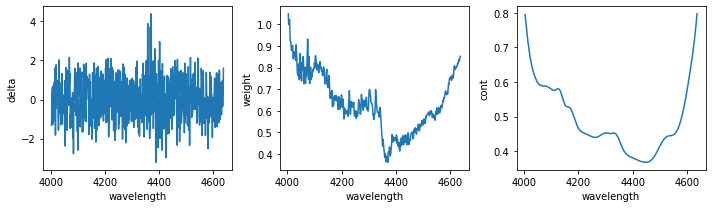

In [61]:
fig,axarr=pl.subplots(1,3,figsize=[10,3])
pl.sca(axarr[0])
pl.plot(wave, delta[obj_ind, :])
pl.xlabel("wavelength")
pl.ylabel("delta")

pl.sca(axarr[1])
pl.plot(wave, weights[obj_ind, :])
pl.xlabel("wavelength")
pl.ylabel("weight")

pl.sca(axarr[2])
pl.plot(wave, cont[obj_ind, :])
pl.xlabel("wavelength")
pl.ylabel("cont")

pl.tight_layout()

In [5]:
# inspect results from one run:
fin = fits.open("/pscratch/sd/q/qhang/desi-lya/delta_F-noise/delta-noisy-desi-footprint-chunk-0.fits")

In [6]:
fin[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   56 / length of dimension 1                          
NAXIS2  =               318261 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    7 / number of table fields                         
TTYPE1  = 'RA      '                                                            
TFORM1  = 'D       '                                                            
TTYPE2  = 'DEC     '                                                            
TFORM2  = 'D       '                                                            
TTYPE3  = 'Z       '        

In [7]:
ra = fin[1].data['RA']
dec = fin[1].data['DEC']

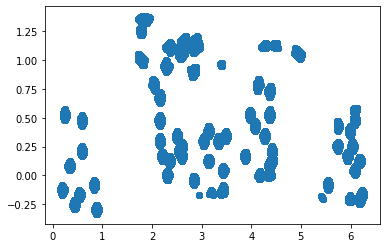

In [8]:
pl.scatter(ra, dec)

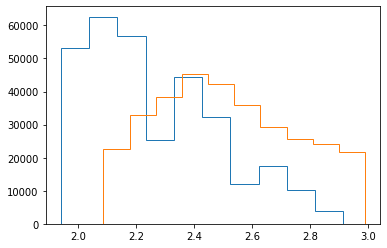

In [9]:
cc=pl.hist(fin[1].data['Z'],histtype='step')
cc=pl.hist(fin[1].data['ZQSO'],histtype='step')

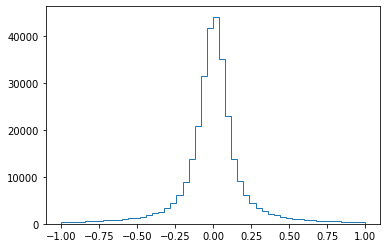

In [10]:
cc=pl.hist(fin[1].data['DELTA_F'],range=[-1,1],bins=50, histtype='step')

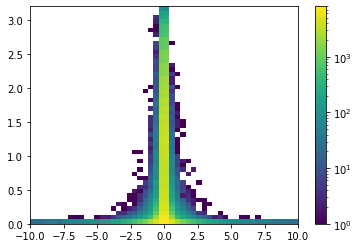

In [12]:
cc=pl.hist2d(fin[1].data['DELTA_F'], fin[1].data['TOTWEIGHTS']/fin[1].data['NPIX'],
            bins=[50,50], norm=colors.LogNorm(),range=[[-10,10],[0,3.2]])
pl.colorbar()

In [16]:
weights = fin[1].data['TOTWEIGHTS']/fin[1].data['NPIX']
print(sum(weights == 0))
print(fin[1].data['DELTA_F'][weights == 0])

36
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
# we can mask some pixels with very low weights (compare with no masking etc.)

# Check combine runs

In [17]:
# functions
def save_catalog_to_fits(fname, data_matrix):
    c=[]
    dtype_to_fits_type = {'int64': 'K',
                          'float64': 'D',
                          'float32': 'E',
                          '<U6': '20A',
                          'bool': 'bool',
                          '>f8': 'D',
                          '>f4': 'E',
                         }
    
    for ii, keys in enumerate(data_matrix.keys()):
        col=fits.Column(name=keys, array=data_matrix[keys],
                        format=dtype_to_fits_type[str(data_matrix[keys].dtype)])
        c.append(col)
    t = fits.BinTableHDU.from_columns(c)
    t.writeto(fname)


In [19]:
keys = ['RA', 'DEC', 'Z', 'ZQSO', 'DELTA_F', 'NPIX', 'TOTWEIGHTS']
data_holder = {}
for key in keys:
    data_holder[key] = np.array([])

nchunks = 16
root = "/pscratch/sd/q/qhang/desi-lya/delta_F-noise/"
for n in range(nchunks):
    fname = root +  f"delta-noisy-desi-footprint-chunk-{n}.fits"
    fin = fits.open(fname)
    for key in keys:
        data_holder[key] = np.append(data_holder[key], fin[1].data[key])

print("Number of objects in chunk: ", len(data_holder["DELTA_F"]))
# save
savename = root + "delta-noisy-desi-footprint.fits"
save_catalog_to_fits(savename, data_holder)
print(f"saved: {savename}")

Number of objects in chunk:  5164256
saved: /pscratch/sd/q/qhang/desi-lya/delta_F-noise/delta-noisy-desi-footprint.fits
